In [1]:
import pyprobound
from matplotlib import pyplot as plt
import asb
import scipy.stats
import numpy as np

In [2]:
alphabet = pyprobound.alphabets.DNA()
dataframe = asb.get_asb_dataframe("CTCF.tsv")
asb_table = asb.ASBTable(
    dataframe, alphabet, left_flank_length=17, right_flank_length=17
)

In [3]:
motifcentral_psam = pyprobound.layers.PSAM(alphabet=alphabet, kernel_size=1)
motifcentral_psam.reload(
    "../likelihood/data/bindingModels/motifcentral_fit_12715.pt"
)

{'time': 'Tue Dec 12 13:17:51 2023',
 'version': '1.1.0',
 'flank_lengths': [(0, 0)]}

In [4]:
asb_psam = pyprobound.layers.PSAM(alphabet=alphabet, kernel_size=1)
asb_psam.reload("CTCF_ASB-psam1.pt")

{'time': 'Fri Dec  8 10:44:11 2023',
 'version': '1.1.0',
 'flank_lengths': (0, 0)}

In [5]:
# mean-center
asb_betas = asb_psam.get_filter(0).detach()[0]
asb_betas -= asb_betas.mean(0)
asb_betas = asb_betas.flatten()

selex_betas = motifcentral_psam.get_filter(0).detach()[0]
selex_betas -= selex_betas.mean(0)
selex_betas = selex_betas.flatten()

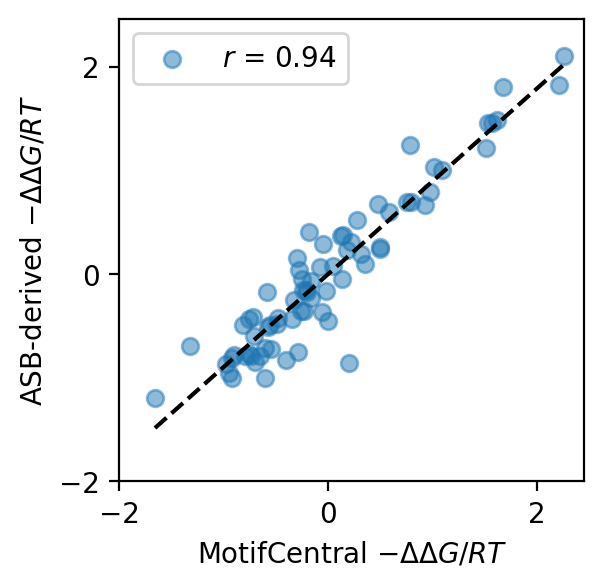

In [6]:
fig, axs = plt.subplots(figsize=(3, 3))

min_lim = min(min(i) for i in (selex_betas, asb_betas)) - 0.2
max_lim = max(max(i) for i in (selex_betas, asb_betas)) + 0.2

# statistics
slope, intercept, pearson, _, _ = scipy.stats.linregress(
    selex_betas, asb_betas
)
spearman = scipy.stats.spearmanr(selex_betas, asb_betas)[0]

# scatter
scatter_label = f"$r$ = {pearson:.2f}"
axs.scatter(selex_betas, asb_betas, label=scatter_label, alpha=0.5)
axs.set_ylim((min_lim, max_lim))
axs.set_xlim((min_lim, max_lim))

# regression
lsrl_x = np.array([min(selex_betas), max(selex_betas)])
lsrl_y = np.array([slope * i + intercept for i in lsrl_x])

# plot
axs.plot(lsrl_x, lsrl_y, "k--")
axs.legend(loc="upper left")
axs.set_xticks([-2, 0, 2])
axs.set_yticks([-2, 0, 2])

axs.set_xlabel(r"MotifCentral $-\Delta\Delta G/RT$")
axs.set_ylabel(r"ASB-derived $-\Delta\Delta G/RT$")
plt.show()